In [ ]:
pip install tensorflow


In [ ]:
import pandas as pd
df_main = pd.read_csv('olid-training-v1.0.tsv', sep='\t')
df_main
X=df_main['tweet']
Y=df_main['subtask_a']
Z=df_main['subtask_b']

Counting Offensive & Not Offensive Labels on training data







Count of "OFF": 4400
Count of "NOT": 8840


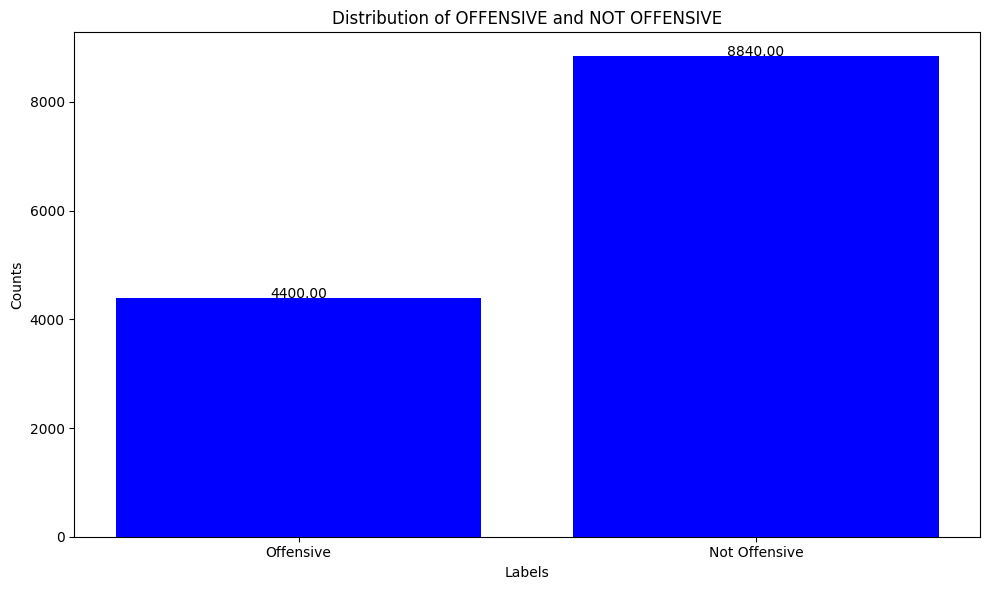

In [ ]:
yes_count = Y.eq("OFF").sum()
no_count = Y.eq("NOT").sum()

print(f'Count of "OFF": {yes_count}')
print(f'Count of "NOT": {no_count}')

import matplotlib.pyplot as plt

labels = ["Offensive","Not Offensive"]
counts = [yes_count, no_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of OFFENSIVE and NOT OFFENSIVE')


for i, value in enumerate(counts):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()

Counting Targeted & Untargeted Labels on training data

Count of "Targeted": 3876
Count of "Untargeted": 524


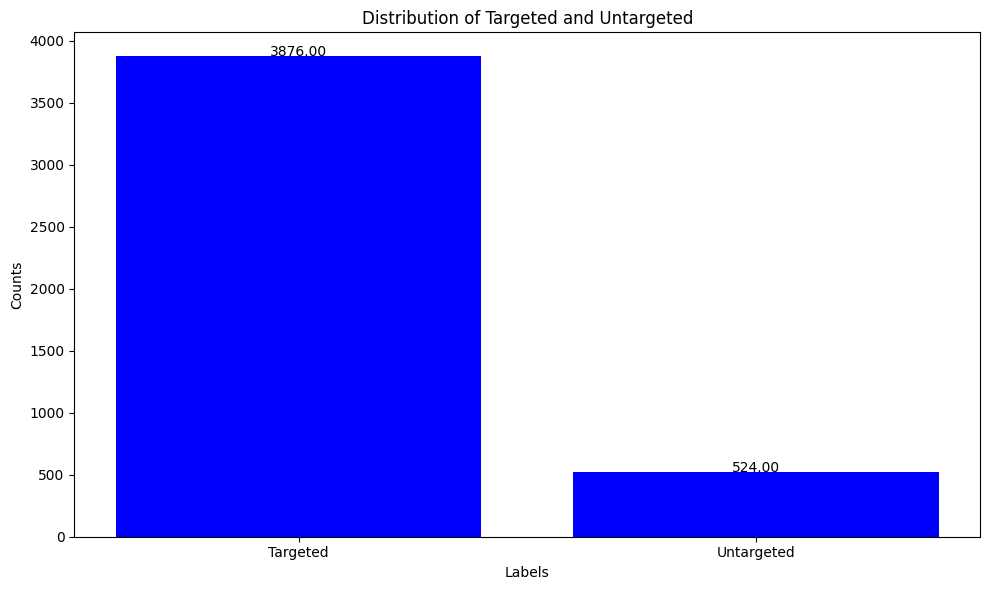

In [ ]:
yes_count = Z.eq("TIN").sum()
no_count = Z.eq("UNT").sum()

print(f'Count of "Targeted": {yes_count}')
print(f'Count of "Untargeted": {no_count}')

import matplotlib.pyplot as plt

labels = ["Targeted","Untargeted"]
counts = [yes_count, no_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Targeted and Untargeted')


for i, value in enumerate(counts):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X = df_main['tweet']
X
arr = X.to_numpy()
print(arr)

['@USER She should ask a few native Americans what their take on this is.'
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT'
 ... "@USER And why report this garbage.  We don't give a crap."
 '@USER Pussy'
 '#Spanishrevenge vs. #justice #HumanRights and #FreedomOfExpression #Spain is a  #fakedemocracy @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER #cddr #shameonSpain #WakeupEurope @USER URL']


Creating Word Corpus for Training Data


In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
arr = X.to_numpy()
print(arr)
for i in range(0, len(arr)):
    review = re.sub('[^a-zA-Z]', ' ', arr[i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

['@USER She should ask a few native Americans what their take on this is.'
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL'
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT'
 ... "@USER And why report this garbage.  We don't give a crap."
 '@USER Pussy'
 '#Spanishrevenge vs. #justice #HumanRights and #FreedomOfExpression #Spain is a  #fakedemocracy @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER #cddr #shameonSpain #WakeupEurope @USER URL']


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
count=0
length=[]
for i in corpus:
    length.append(len(i))
print(max(length))
print(min(length))
sum=0
for i in length:
    sum+=i
print("average",round(sum/len(length)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


416
4
average 74


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

voc_size=5000
onehot_repr=[one_hot(words,voc_size)for words in corpus]
#onehot_repr

Embedding


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  221 4350  133]
 [   0    0    0 ... 4424  429  420]
 [2590 2731 3047 ... 3090 4154 4161]
 ...
 [   0    0    0 ... 2926  125 4709]
 [   0    0    0 ...    0 2354 2080]
 [2354 2354 2354 ... 1443 2354  420]]


Creating Unidirectional LSTM model


In [ ]:
embedding_vector_features=40
uni_lstm=Sequential()
uni_lstm.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
uni_lstm.add(LSTM(10))
uni_lstm.add(Dense(1,activation='tanh'))
uni_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(uni_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 10)                2040      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 202,051
Trainable params: 202,051
Non-trainable params: 0
_________________________________________________________________
None


Creating Bidirectional LSTM model

In [ ]:
embedding_vector_features=40
bi_lstm=Sequential()
bi_lstm.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
bi_lstm.add(Bidirectional(LSTM(2)))
bi_lstm.add(Dropout(0.3))
bi_lstm.add(Dense(1,activation='tanh'))
bi_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(bi_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 4)                688       
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 200,693
Trainable params: 200,693
Non-trainable params: 0
_________________________________________________________________
None


Creating Bidirectional GRU model

In [ ]:
vocab_size = 5000
embedding_dim = 40
max_sequence_length = 20
hidden_units = 2
num_classes = 1
bi_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(GRU(units=hidden_units, return_sequences=False)),
    Dense(num_classes, activation='tanh')
])

In [ ]:
bi_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Preparing Testing data for **Task A**

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df = pd.read_csv('testset-levela.tsv', sep='\t')
df=df.dropna()
x=df['tweet']
y = pd.read_csv("labels-levela.csv", header = None)

y.drop(y.columns[[0]], axis=1, inplace=True)
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus2 = []
arr2 = x.to_numpy()

for i in range(0, len(arr2)):
    review = re.sub('[^a-zA-Z]', ' ', arr2[i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus2.append(review)
onehot_repr2=[one_hot(words,voc_size)for words in corpus2]
sent_length=20
embedded_docs2=pad_sequences(onehot_repr2,padding='pre',maxlen=sent_length)
import numpy as np
X_a_test=np.array(embedded_docs2)
y_a_test=np.array(y)
y_a_test = enc.fit_transform(y_a_test)
print(len(y_a_test))

860


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import nltk
nltk.download('punkt')  # Download necessary data
from nltk.tokenize import word_tokenize
count=0
length=[]
for i in corpus2:
    length.append(len(i))
print(max(length))
print(min(length))
sum=0
for i in length:
    sum+=i
print("average",round(sum/len(length)))

236
7
average 88


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Counting Offensive & Not Offenvise Labels on testing data

Count of "OFF": 240
Count of "NOT": 620


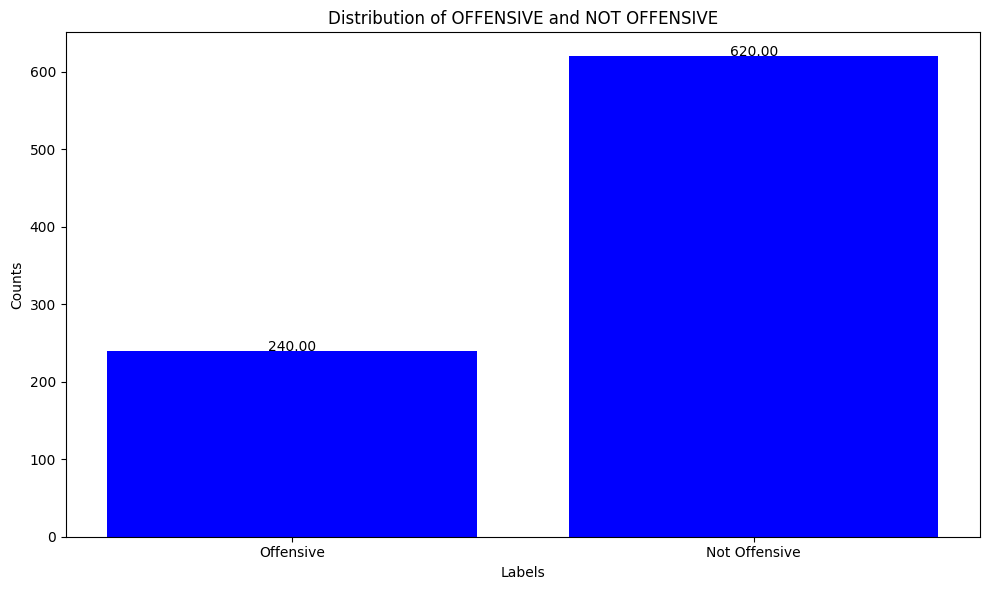

In [ ]:
yes_count = 0
no_count = 0
for i in y_a_test:
    if i==1:
        yes_count+=1
    else:
        no_count+=1

print(f'Count of "OFF": {yes_count}')
print(f'Count of "NOT": {no_count}')

import matplotlib.pyplot as plt

labels = ["Offensive","Not Offensive"]
counts = [yes_count, no_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of OFFENSIVE and NOT OFFENSIVE')


for i, value in enumerate(counts):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# enc = LabelEncoder()

# Y = enc.fit_transform(Y)
# Y

In [ ]:
import numpy as np

X_a_train=np.array(embedded_docs)
y_a_train=np.array(Y)

y_a_train = enc.fit_transform(y_a_train)
print(y_a_train)

[1 1 0 ... 1 1 0]


Training Unidirectional LSTM model for **Task A**

In [ ]:
uni_lstm.fit(X_a_train,y_a_train,validation_data=(X_a_test,y_a_test),epochs=10,batch_size=64)

Epoch 1/10
207/207 [==============================] - 8s 24ms/step - loss: 0.6583 - accuracy: 0.6718 - val_loss: 0.5291 - val_accuracy: 0.7430
Epoch 2/10
207/207 [==============================] - 3s 16ms/step - loss: 0.4983 - accuracy: 0.7669 - val_loss: 0.6074 - val_accuracy: 0.7744
Epoch 3/10
207/207 [==============================] - 3s 16ms/step - loss: 0.4316 - accuracy: 0.8079 - val_loss: 0.7315 - val_accuracy: 0.7942
Epoch 4/10
207/207 [==============================] - 4s 20ms/step - loss: 0.3916 - accuracy: 0.8279 - val_loss: 0.7240 - val_accuracy: 0.7686
Epoch 5/10
207/207 [==============================] - 3s 17ms/step - loss: 0.3467 - accuracy: 0.8578 - val_loss: 0.9894 - val_accuracy: 0.7558
Epoch 6/10
207/207 [==============================] - 3s 16ms/step - loss: 0.3108 - accuracy: 0.8786 - val_loss: 1.1271 - val_accuracy: 0.6698
Epoch 7/10
207/207 [==============================] - 3s 16ms/step - loss: 0.3254 - accuracy: 0.8721 - val_loss: 1.3457 - val_accuracy: 0.7372

Testing Unidirectional LSTM model and finding Accuracy for **Task A**


In [ ]:
y_pred1=uni_lstm.predict(X_a_test)
import numpy as np


from sklearn.metrics import accuracy_score

data=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred1:
    for j in i:
        data.append(j)


binary_data1 = [map_to_binary_between_minus_one_and_one(value) for value in data]

accuracy = accuracy_score(y_a_test, binary_data1)
print("Accuracy:", accuracy)
print(len(y_pred1))



27/27 [==============================] - 1s 3ms/step
Accuracy: 0.5767441860465117
860


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task A** by Unidirectional LSTM model


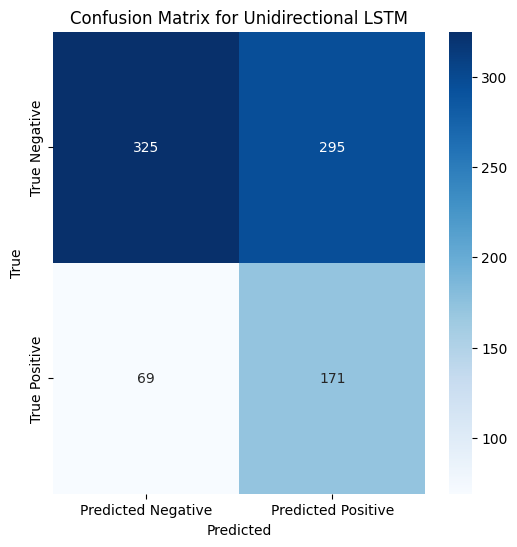

Precision: 0.3669527896995708
Recall: 0.7125
F1 Score: 0.4844
F2 Score: 0.5996


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_a_test, binary_data1)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Unidirectional LSTM")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_a_test, binary_data1)
recall = recall_score(y_a_test, binary_data1)

print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import f1_score, fbeta_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_a_train, y_a_train)

y_pred = clf.predict(X_a_test)

f1 = f1_score(y_a_test, binary_data1)

f2 = fbeta_score(y_a_test, binary_data1, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")


Training Bidirectional LSTM model for **Task A**

In [ ]:
bi_lstm.fit(X_a_train,y_a_train,epochs=10,batch_size=64)

Epoch 1/10
207/207 [==============================] - 10s 26ms/step - loss: 0.9124 - accuracy: 0.6681
Epoch 2/10
207/207 [==============================] - 4s 20ms/step - loss: 0.6173 - accuracy: 0.6835
Epoch 3/10
207/207 [==============================] - 6s 30ms/step - loss: 0.5528 - accuracy: 0.7271
Epoch 4/10
207/207 [==============================] - 4s 21ms/step - loss: 0.5032 - accuracy: 0.7609
Epoch 5/10
207/207 [==============================] - 4s 20ms/step - loss: 0.4805 - accuracy: 0.7829
Epoch 6/10
207/207 [==============================] - 5s 26ms/step - loss: 0.4503 - accuracy: 0.8000
Epoch 7/10
207/207 [==============================] - 5s 22ms/step - loss: 0.4615 - accuracy: 0.7917
Epoch 8/10
207/207 [==============================] - 4s 21ms/step - loss: 0.4313 - accuracy: 0.8205
Epoch 9/10
207/207 [==============================] - 5s 26ms/step - loss: 0.3977 - accuracy: 0.8301
Epoch 10/10
207/207 [==============================] - 4s 20ms/step - loss: 0.3796 - accur

Testing Bidirectional LSTM model and finding Accuracy for **Task A**

In [ ]:
y_pred2=bi_lstm.predict(X_a_test)
import numpy as np
from sklearn.metrics import accuracy_score

continuous_data=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred2:
    for j in i:
        continuous_data.append(j)


binary_data = [map_to_binary_between_minus_one_and_one(value) for value in continuous_data]

accuracy = accuracy_score(y_a_test, binary_data)
print("Accuracy:", accuracy)


27/27 [==============================] - 1s 4ms/step
Accuracy: 0.536046511627907


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task A** by Bidirectional LSTM model

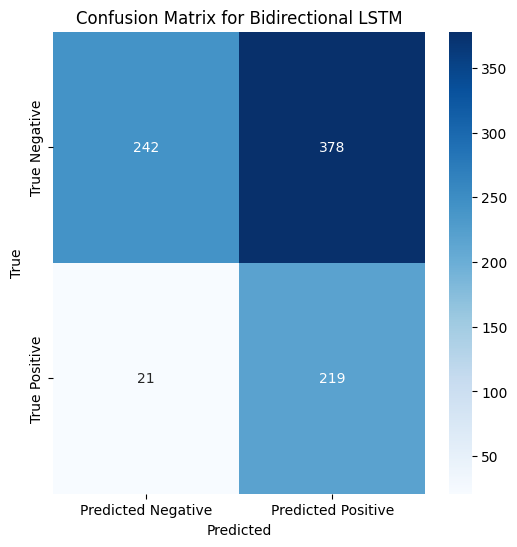

Precision: 0.36683417085427134
Recall: 0.9125
F1 Score: 0.5233
F2 Score: 0.7033


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, fbeta_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

cm = confusion_matrix(y_a_test, binary_data)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Bidirectional LSTM")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_a_test, binary_data)
recall = recall_score(y_a_test, binary_data)

print("Precision:", precision)
print("Recall:", recall)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_a_train, y_a_train)

y_pred = clf.predict(X_a_test)

f1 = f1_score(y_a_test, binary_data)

f2 = fbeta_score(y_a_test, binary_data, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")

Training Bidirectional GRU model for **Task A**

In [ ]:
bi_gru.fit(X_a_train, y_a_train, validation_data=(X_a_test,y_a_test), epochs=10 , batch_size=64)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


207/207 [==============================] - 11s 26ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 2/10
207/207 [==============================] - 6s 29ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 3/10
207/207 [==============================] - 5s 22ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 4/10
207/207 [==============================] - 5s 22ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 5/10
207/207 [==============================] - 6s 28ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 6/10
207/207 [==============================] - 5s 23ms/step - loss: 3.9616e-08 - accuracy: 0.6677 - val_loss: 3.3268e-08 - val_accuracy: 0.7209
Epoch 7/10
207/207 [==============================] - 6s 29ms/step - loss: 3.9616e-08 - accuracy: 0.6677

Testing Bidirectional GRU model and finding Accuracy for **Task A**

In [ ]:
y_pred3=bi_gru.predict(X_a_test)
import numpy as np
from sklearn.metrics import accuracy_score

continuous=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred3:
    for j in i:
        continuous.append(j)


binary = [map_to_binary_between_minus_one_and_one(value) for value in continuous]

accuracy = accuracy_score(y_a_test, binary)
print("Accuracy:", accuracy)

27/27 [==============================] - 2s 14ms/step
Accuracy: 0.672093023255814


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task A** by Bidirectional GRU model

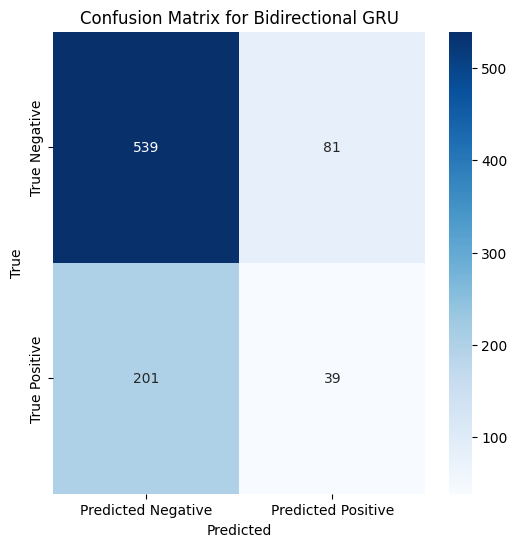

Precision: 0.325
Recall: 0.1625
F1 Score: 0.2167
F2 Score: 0.1806


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, fbeta_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

cm = confusion_matrix(y_a_test, binary)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Bidirectional GRU")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_a_test, binary)
recall = recall_score(y_a_test, binary)

print("Precision:", precision)
print("Recall:", recall)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_a_train, y_a_train)

y_pred = clf.predict(X_a_test)

f1 = f1_score(y_a_test, binary)

f2 = fbeta_score(y_a_test, binary, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")

In [ ]:
X_b_train = df_main['tweet']
X_b_train = X_b_train[df_main['subtask_b'].notnull()]
#X_b.head()
print(len(X_b_train))
y_b_train = df_main['subtask_b']
y_b_train = y_b_train[df_main['subtask_b'].notnull()]
y_b_train = enc.fit_transform(y_b_train)
y_b_train

4400


array([1, 0, 1, ..., 0, 0, 1])

Preparing Testing data for **Task B**

In [ ]:
import pandas as pd
df = pd.read_csv('testset-levelb.tsv', sep='\t')
df=df.dropna()
X_b_test=df['tweet']
y_b = pd.read_csv("labels-levelb.csv", header = None)

y_b.drop(y_b.columns[[0]], axis=1, inplace=True)
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus3 = []
arr3 = X_b_test.to_numpy()

for i in range(0, len(arr3)):
    review = re.sub('[^a-zA-Z]', ' ', arr3[i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus3.append(review)
onehot_repr3=[one_hot(words,voc_size)for words in corpus3]
sent_length=20
embedded_docs3=pad_sequences(onehot_repr3,padding='pre',maxlen=sent_length)
import numpy as np
X_b_test=np.array(embedded_docs3)
y_b_test=np.array(y_b)
y_b_test = enc.fit_transform(y_b_test)
print(y_b_test)

[0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
count=0
length=[]
for i in corpus3:
    length.append(len(i))
print(max(length))
print(min(length))
sum=0
for i in length:
    sum+=i
print("average",round(sum/len(length)))

220
7
average 84


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Counting Targeted & Untargeted Labels on testing data

Count of "Targeted": 213
Count of "Untargeted": 27


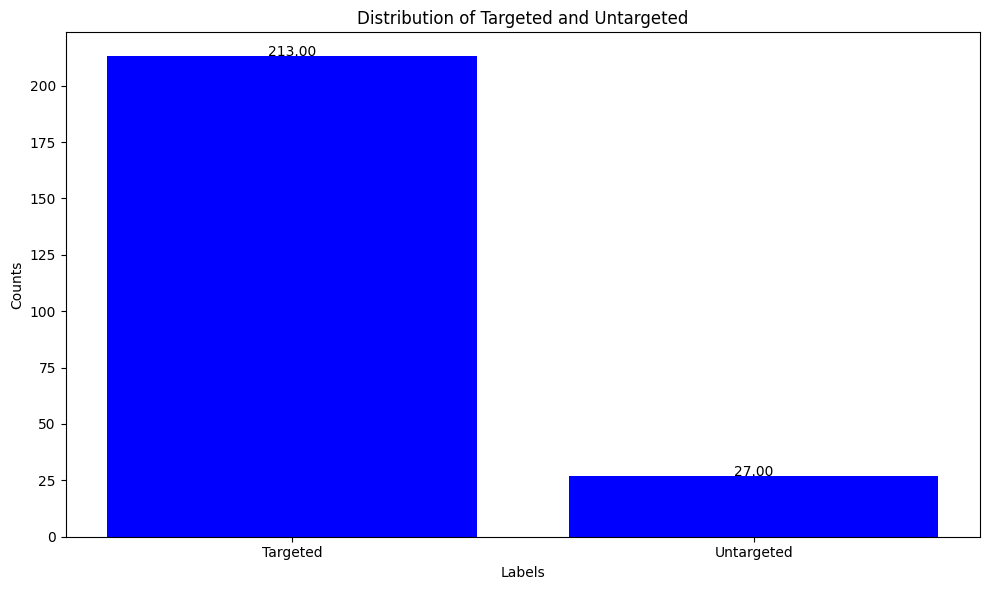

In [ ]:
yes_count = 0
no_count = 0
for i in y_b_test:
    if i==0:
        yes_count+=1
    else:
        no_count+=1

print(f'Count of "Targeted": {yes_count}')
print(f'Count of "Untargeted": {no_count}')

import matplotlib.pyplot as plt

labels = ["Targeted","Untargeted"]
counts = [yes_count, no_count]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='blue')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Targeted and Untargeted')


for i, value in enumerate(counts):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpusb = []
arrb = X_b_train.to_numpy()

for i in range(0, len(arrb)):
    review = re.sub('[^a-zA-Z]', ' ', arrb[i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpusb.append(review)

In [ ]:
#corpusb

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

voc_size=5000
onehot_repr_b=[one_hot(words,voc_size)for words in corpusb]
#onehot_repr_b

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sent_length=20
embedded_docs_b=pad_sequences(onehot_repr_b,padding='pre',maxlen=sent_length)
print(len(embedded_docs_b))
X_b_train=np.array(embedded_docs_b)
print(X_b_train)

4400
[[   0    0    0 ...  221 4350  133]
 [   0    0    0 ... 4424  429  420]
 [   0    0    0 ... 2180 1369 3318]
 ...
 [   0    0    0 ... 1519 2967 1109]
 [   0    0    0 ... 2926  125 4709]
 [   0    0    0 ...    0 2354 2080]]


In [ ]:
#X_b_train=np.array(embedded_docs3)
print(len(y_b_test))
print(len(y_b_train))
print(len(X_b_train))
print(len(X_b_test))

240
4400
4400
240


Training Unidirectional LSTM model for **Task B**

In [ ]:
uni_lstm.fit(X_b_train,y_b_train,validation_data=(X_b_test,y_b_test),epochs=10,batch_size=64)

Epoch 1/10
69/69 [==============================] - 1s 18ms/step - loss: 1.3456 - accuracy: 0.7850 - val_loss: 1.3917 - val_accuracy: 0.8667
Epoch 2/10
69/69 [==============================] - 1s 17ms/step - loss: 0.8451 - accuracy: 0.8509 - val_loss: 0.9330 - val_accuracy: 0.8542
Epoch 3/10
69/69 [==============================] - 1s 17ms/step - loss: 0.6394 - accuracy: 0.8880 - val_loss: 0.9075 - val_accuracy: 0.8667
Epoch 4/10
69/69 [==============================] - 1s 16ms/step - loss: 0.5757 - accuracy: 0.8977 - val_loss: 0.9475 - val_accuracy: 0.8750
Epoch 5/10
69/69 [==============================] - 1s 17ms/step - loss: 0.5437 - accuracy: 0.9020 - val_loss: 0.9903 - val_accuracy: 0.8792
Epoch 6/10
69/69 [==============================] - 1s 16ms/step - loss: 0.5184 - accuracy: 0.9109 - val_loss: 0.9918 - val_accuracy: 0.8792
Epoch 7/10
69/69 [==============================] - 2s 25ms/step - loss: 0.5007 - accuracy: 0.9145 - val_loss: 0.9957 - val_accuracy: 0.8750
Epoch 8/10
69

Training Bidirectional LSTM model for **Task B**

In [ ]:
bi_lstm.fit(X_b_train,y_b_train,validation_data=(X_b_test,y_b_test),epochs=10,batch_size=64)

Epoch 1/10
69/69 [==============================] - 3s 47ms/step - loss: 0.8834 - accuracy: 0.7059 - val_loss: 0.8855 - val_accuracy: 0.8208
Epoch 2/10
69/69 [==============================] - 1s 21ms/step - loss: 0.5215 - accuracy: 0.8248 - val_loss: 0.5210 - val_accuracy: 0.8500
Epoch 3/10
69/69 [==============================] - 1s 21ms/step - loss: 0.4426 - accuracy: 0.8761 - val_loss: 0.5138 - val_accuracy: 0.8625
Epoch 4/10
69/69 [==============================] - 1s 20ms/step - loss: 0.3775 - accuracy: 0.8839 - val_loss: 0.5418 - val_accuracy: 0.8750
Epoch 5/10
69/69 [==============================] - 1s 21ms/step - loss: 0.3633 - accuracy: 0.8930 - val_loss: 0.5596 - val_accuracy: 0.8875
Epoch 6/10
69/69 [==============================] - 1s 21ms/step - loss: 0.3263 - accuracy: 0.8980 - val_loss: 0.6552 - val_accuracy: 0.8875
Epoch 7/10
69/69 [==============================] - 1s 21ms/step - loss: 0.3427 - accuracy: 0.9000 - val_loss: 0.7454 - val_accuracy: 0.8875
Epoch 8/10
69

Training Bidirectional GRU model for **Task B**

In [ ]:
bi_gru.fit(X_b_train, y_b_train, validation_data=(X_b_test,y_b_test), epochs=10 , batch_size=64)

Epoch 1/10
69/69 [==============================] - 2s 23ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 2/10
69/69 [==============================] - 2s 23ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 3/10
69/69 [==============================] - 1s 22ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 4/10
69/69 [==============================] - 1s 21ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 5/10
69/69 [==============================] - 2s 25ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 6/10
69/69 [==============================] - 2s 36ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - val_loss: 1.3411e-08 - val_accuracy: 0.8875
Epoch 7/10
69/69 [==============================] - 2s 22ms/step - loss: 1.4197e-08 - accuracy: 0.8809 - v

Testing Unidirectional LSTM model and finding Accuracy for **Task B**

In [ ]:
y_pred_1=uni_lstm.predict(X_b_test)
import numpy as np


from sklearn.metrics import accuracy_score

data1=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred_1:
    for j in i:
        data1.append(j)


binary_data2 = [map_to_binary_between_minus_one_and_one(value) for value in data1]

accuracy = accuracy_score(y_b_test, binary_data2)
print("Accuracy:", accuracy)

8/8 [==============================] - 0s 5ms/step
Accuracy: 0.7625


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task B** by Unidirectional LSTM model

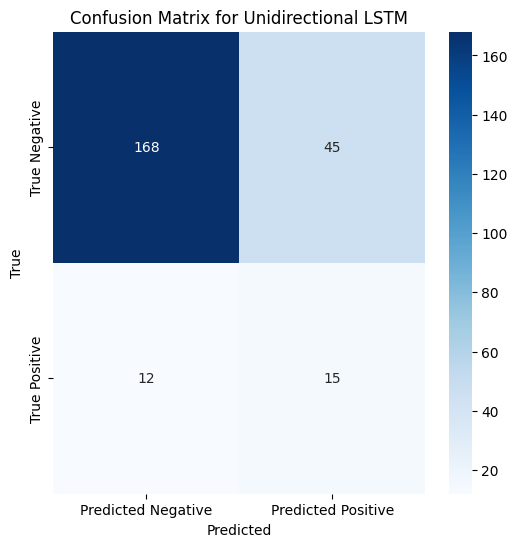

Precision: 0.25
Recall: 0.5555555555555556
F1 Score: 0.3448
F2 Score: 0.4464


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_b_test, binary_data2)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Unidirectional LSTM")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_b_test, binary_data2)
recall = recall_score(y_b_test, binary_data2)

print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import f1_score, fbeta_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_b_train, y_b_train)

y_pred = clf.predict(X_b_test)

f1 = f1_score(y_b_test, binary_data2)

f2 = fbeta_score(y_b_test, binary_data2, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")


Testing Bidirectional LSTM model and finding Accuracy for **Task B**

In [ ]:
y_pred_2=bi_lstm.predict(X_b_test)
import numpy as np


from sklearn.metrics import accuracy_score

data3=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred_2:
    for j in i:
        data3.append(j)


binary_data3 = [map_to_binary_between_minus_one_and_one(value) for value in data3]

accuracy = accuracy_score(y_b_test, binary_data3)
print("Accuracy:", accuracy)

8/8 [==============================] - 0s 5ms/step
Accuracy: 0.6291666666666667


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task B** by Biidirectional LSTM model

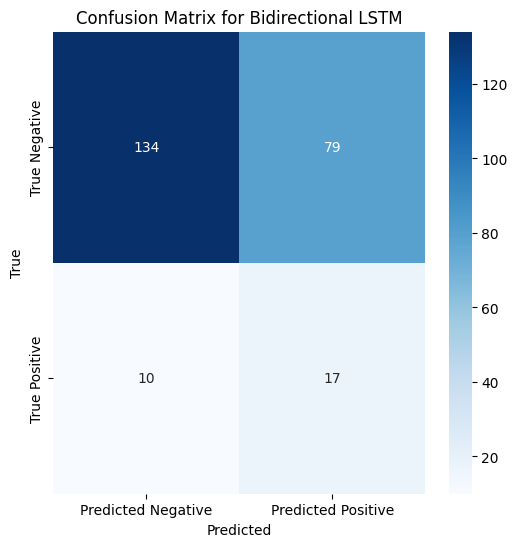

Precision: 0.17708333333333334
Recall: 0.6296296296296297
F1 Score: 0.2764
F2 Score: 0.4167


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_b_test, binary_data3)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Bidirectional LSTM")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_b_test, binary_data3)
recall = recall_score(y_b_test, binary_data3)

print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import f1_score, fbeta_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_b_train, y_b_train)

y_pred = clf.predict(X_b_test)

f1 = f1_score(y_b_test, binary_data3)

f2 = fbeta_score(y_b_test, binary_data3, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")


Testing Bidirectional GRU model and finding Accuracy for **Task B**

In [ ]:
y_pred_3=bi_gru.predict(X_b_test)
import numpy as np


from sklearn.metrics import accuracy_score

data4=[]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def map_to_binary_between_minus_one_and_one(value):
    mapped_value = sigmoid(value)
    return round(mapped_value)

for i in y_pred_3:
    for j in i:
        data4.append(j)


binary_data4 = [map_to_binary_between_minus_one_and_one(value) for value in data4]

accuracy = accuracy_score(y_b_test, binary_data4)
print("Accuracy:", accuracy)

8/8 [==============================] - 0s 5ms/step
Accuracy: 0.775


Creating Confusion Matrix and finding Precision, Recall, F1 & F2 Score on **Task B** by Bidirectional GRU model

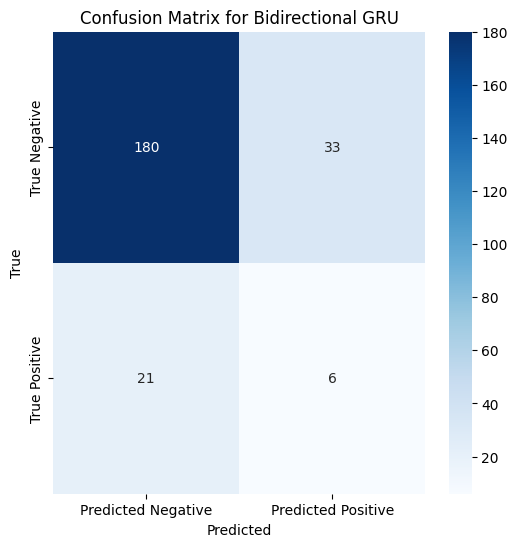

Precision: 0.15384615384615385
Recall: 0.2222222222222222
F1 Score: 0.1818
F2 Score: 0.2041


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_b_test, binary_data4)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Bidirectional GRU")
plt.show()

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_b_test, binary_data4)
recall = recall_score(y_b_test, binary_data4)

print("Precision:", precision)
print("Recall:", recall)

from sklearn.metrics import f1_score, fbeta_score
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split




clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_b_train, y_b_train)


y_pred = clf.predict(X_b_test)


f1 = f1_score(y_b_test, binary_data4)

f2 = fbeta_score(y_b_test, binary_data4, beta=2)

print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")


In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
dctnry={}
for i in corpus:
    words = word_tokenize(i)
    for j in words:
        if j not in dctnry:
            dctnry[j]=0
        dctnry[j]+=1

dctnry.pop("user")
dctnry.pop("url")
maxi=max(dctnry.values())
mini=min(dctnry.values())
for key, val in dctnry.items():
    if val==maxi:
        print(key)
        break
for key, val in dctnry.items():
    if val==mini:
        print(key)
        break

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


liber
vetaken


In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
dctnry={}
for i in corpus2:
    words = word_tokenize(i)
    for j in words:
        if j not in dctnry:
            dctnry[j]=0
        dctnry[j]+=1

dctnry.pop("user")
dctnry.pop("url")
maxi=max(dctnry.values())
mini=min(dctnry.values())
for key, val in dctnry.items():
    if val==maxi:
        print(key)
        break
for key, val in dctnry.items():
    if val==mini:
        print(key)
        break


liber
whoisq


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
dctnry={}
for i in corpus3:
    words = word_tokenize(i)
    for j in words:
        if j not in dctnry:
            dctnry[j]=0
        dctnry[j]+=1

dctnry.pop("user")
dctnry.pop("url")
maxi=max(dctnry.values())
mini=min(dctnry.values())
for key, val in dctnry.items():
    if val==maxi:
        print(key)
        break
for key, val in dctnry.items():
    if val==mini:
        print(key)
        break


liber
whoisq


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**References**

1. ChatGPT

2. Github: https://github.com/krishnaik06/Fake-New-LSTM/blob/master/FakeNewsClassifierUsingBidirectionalLSTM.ipynb